# Do interface design to further filter out unproductive designs prior to looping

In [11]:
# %load_ext lab_black
# Python standard library
from glob import glob
import os
import socket
import sys

# 3rd party library imports
import dask
import matplotlib.pyplot as plt
import pandas as pd
import pyrosetta
import numpy as np
import scipy
import seaborn as sns
from tqdm.auto import tqdm  # jupyter compatible progress bar

sys.path.insert(0, "/home/broerman/projects/crispy_shifty")

tqdm.pandas()  # link tqdm to pandas
# Notebook magic
# save plots in the notebook
%matplotlib inline
# reloads modules automatically before executing cells
%load_ext autoreload
%autoreload 2
print(f"running in directory: {os.getcwd()}")  # where are we?
print(f"running on node: {socket.gethostname()}")  # what node are we on?

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
running in directory: /home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/test_sampling
running on node: sofia


In [7]:
import pyrosetta.distributed.cluster as cluster

allowed_parents = ['DHR39', 'DHR62', 'DHR82']
parent_counts = {'DHR39': 0, 'DHR62': 0, 'DHR82': 0}

states_file = "/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/01_make_states/states.list"
states_sample_file = "/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/01_make_states/states_sample.list"
with open(states_file, "r") as f:
    with open(states_sample_file, 'w') as f_sample:
        for line in f:
            parent = cluster.get_scores_dict(line.rstrip())["scores"]['parent']
            if parent in allowed_parents:
                f_sample.write(line)
                parent_counts[parent] += 1
print(parent_counts)

{'DHR39': 16, 'DHR62': 12, 'DHR82': 12}


In [2]:
# I had about 10 samples per design last round, and it was not enough. So, kick sampling up an order of magnitude.

from crispy_shifty.utils.io import gen_array_tasks

design_list_file = "/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/01_make_states/states_sample.list"
output_path = "/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/test_sampling/02_design_filter"

# Format as a string of key value pairs with no leading dashes on the argument names
options = "out:level 100 holes:dalphaball /home/bcov/ppi/tutorial_build/main/source/external/DAlpahBall/DAlphaBall.gcc indexed_structure_store:fragment_store /home/bcov/sc/scaffold_comparison/data/ss_grouped_vall_all.h5 precompute_ig true"

gen_array_tasks(distribute_func='crispy_shifty.protocols.design.one_state_design_unlooped_dimer',
                design_list_file=design_list_file,
                output_path=output_path,
                queue='backfill',
                memory='13G',
                nstruct=100,
                options=options,
                simulation_name='02_design_filter')

/projects/crispy_shifty/envs/crispy/lib/python3.8/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


Run the following command with your desired environment active:
sbatch -a 1-$(cat /home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/test_sampling/02_design_filter/tasks.cmds | wc -l) /home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/test_sampling/02_design_filter/run.sh


In [23]:
!sjobs -J 65432354 > 02_design_filter/backfill_jobs.json

In [24]:
jobs_df = pd.read_json('02_design_filter/backfill_jobs.json')
jobs_df

,JobID,Step,Task,JobName,Start,Wait,Partition,User,Elapsed,NNodes,NCPUS,UserCPU,pCPU,ReqMem,MemUsed,pMem,State
0,65432354,NaN,1,02_design_filter,1639077860,1,backfill,broerman,8965,1,1,87.83,NaN,12582912,10341284,82.185141,COMPLETED
1,65432354,NaN,2,02_design_filter,1639144209,4967,backfill,broerman,8631,1,1,85.8,NaN,12582912,10397028,82.628155,COMPLETED
2,65432354,NaN,3,02_design_filter,1639077860,1,backfill,broerman,8337,1,1,79.47,NaN,12582912,10300236,81.858921,COMPLETED
3,65432354,NaN,4,02_design_filter,1639143853,5729,backfill,broerman,11577,1,1,114.44,NaN,12582912,3760,0.029882,COMPLETED
4,65432354,NaN,5,02_design_filter,1639077860,1,backfill,broerman,9412,1,1,92.3,NaN,12582912,10928920,86.855253,COMPLETED
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,65432354,NaN,3996,02_design_filter,1639113303,218,backfill,broerman,9849,1,1,97.5,NaN,13631488,9446428,69.298583,COMPLETED
3996,65432354,NaN,3997,02_design_filter,1639117078,554,backfill,broerman,8873,1,1,87.82,NaN,13631488,9273668,68.031223,COMPLETED
3997,65432354,NaN,3998,02_design_filter,1639133609,157,backfill,broerman,10720,1,1,139.34,NaN,13631488,11054016,81.091778,COMPLETED
3998,65432354,NaN,3999,02_design_filter,1639087339,9480,backfill,broerman,8694,1,1,86.09,NaN,13631488,7972040,58.482537,COMPLETED


In [26]:
failed_jobs_df = jobs_df[jobs_df['State'] != 'COMPLETED']
failed_jobs_df

,JobID,Step,Task,JobName,Start,Wait,Partition,User,Elapsed,NNodes,NCPUS,UserCPU,pCPU,ReqMem,MemUsed,pMem,State
9,65432354,NaN,10,02_design_filter,1639107042,20979,backfill,broerman,407,1,1,06:03.043,NaN,12582912,5306680,42.173704,OUT_OF_MEMORY
88,65432354,NaN,89,02_design_filter,1639087842,127,backfill,broerman,582,1,1,08:24.013,NaN,12582912,12025300,95.568498,CANCELLED
90,65432354,NaN,91,02_design_filter,1639087861,146,backfill,broerman,43213,1,1,,NaN,12582912,66852,0.531292,CANCELLED
129,65432354,NaN,130,02_design_filter,1639077863,4,backfill,broerman,440,1,1,05:48.898,NaN,12582912,4885516,38.826593,OUT_OF_MEMORY
130,65432354,NaN,131,02_design_filter,1639109566,235,backfill,broerman,1190,1,1,18:21.007,NaN,12582912,11630404,92.430147,CANCELLED
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3940,65432354,NaN,3941,02_design_filter,1639087162,9303,backfill,broerman,1262,1,1,19:23.012,NaN,13631488,8210344,60.230725,CANCELLED
3947,65432354,NaN,3948,02_design_filter,1639108395,20821,backfill,broerman,2358,1,1,38:19.023,NaN,13631488,6620376,48.566789,CANCELLED
3958,65432354,NaN,3959,02_design_filter,1639087177,9318,backfill,broerman,1247,1,1,19:24.014,NaN,13631488,7158400,52.513709,CANCELLED
3972,65432354,NaN,3973,02_design_filter,1639087254,9395,backfill,broerman,969,1,1,00:00.572,NaN,13631488,66852,0.490423,FAILED


In [29]:
os.rename('02_design_filter/tasks.cmds', '02_design_filter/old_tasks.cmds')
with open('02_design_filter/old_tasks.cmds', 'r') as f:
    tasks = f.readlines()
with open('02_design_filter/tasks.cmds', 'w') as f_new:
    for task_ind in failed_jobs_df['Task']:
        f_new.write(tasks[task_ind])

In [ ]:
from crispy_shifty.utils.io import collect_score_file
output_path = "/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/test_sampling/02_design_filter"
collect_score_file(output_path, 'scores')

In [16]:
# Fix how some of the score values are missing quotation marks, which causes problems down the road with my existing filtering code
# Only need to run once

import os

def quote_scorefile(scores_file, output_file):
    import json
    with open(scores_file, 'r') as f:
        with open(output_file, 'a') as out:
            for line in f:
                data = json.loads(line)
                # print(data)
                
                for scores_dict in data.values(): # just one value in the dict
                    for key, value in scores_dict.items():
                        scores_dict[key] = str(value)
                    for key, value in data.items(): # just one item in the dict
                        data[key] = scores_dict
                    # print(data)
                    out.write(json.dumps(data) + '\n')

os.chdir("/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers")
output_path_1 = os.path.join(os.getcwd(), "02_design_filter_2")
output_path_2 = os.path.join(os.getcwd(), "02_design_filter_3")

combined_path = os.path.join(output_path_2, "combined_scores.json")
if os.path.exists(combined_path):
    os.remove(combined_path)

scores_1 = os.path.join(output_path_1, "scores.json")
quote_scorefile(scores_1, combined_path)
scores_2 = os.path.join(output_path_2, "scores.json")
quote_scorefile(scores_2, combined_path)

In [2]:
# Now that I've sufficiently sampled most of the inputs, read the new final scorefiles and filter

def read_scorefile(scores):
    import pandas as pd

    scores = pd.read_json(scores, orient="records", typ="frame", lines=True)
    scores = scores.T
    mat = scores.values
    n = mat.shape[0]
    dicts = list(mat[range(n), range(n)])
    index = scores.index
    tabulated_scores = pd.DataFrame(dicts, index=index)
    return tabulated_scores

os.chdir("/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers")
output_path_2 = os.path.join(os.getcwd(), "02_design_filter_3")
combined_path = os.path.join(output_path_2, "combined_scores.json")
scores_df = read_scorefile(combined_path)

scores_df

,bb_clash,bb_clash_A,bb_clash_B,cms_ac_bn,cms_dhr,cms_dhr_ac,cms_dhr_bn,dhr_ac_int_count,dhr_bn_int_count,dhr_int_count,...,shift_A,shift_B,ss_sc,total_score,wnm_1,wnm_2,wnm_3,wnm_4,wnm_hlx,yhh_planarity
/mnt/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/02_design_filter_2/decoys/0000/02_design_filter_83c01e16672540ed8ed810910e3347c4.pdb.bz2,386.6686706542969,82.80949401855469,303.8587341308594,40.377952575683594,273.8495178222656,350.3719177246094,212.23387145996094,20.0,10.0,14.0,...,2.0,6.0,0.7084348201751709,14914.797802444302,0.32737863063812256,0.3035939037799835,0.33877745270729065,0.3090043365955353,0.09491097182035446,0.0015607019201308026
/mnt/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/02_design_filter_2/decoys/0000/02_design_filter_ace7a3318b364324979390173c9c9bab.pdb.bz2,3342.748291015625,3297.4052734375,45.342857360839844,0.4830004870891571,172.35617065429688,172.35617065429688,554.2578125,11.0,19.0,13.0,...,5.0,-5.0,0.7809131741523743,14685.350251101356,0.320171594619751,0.27292415499687195,0.3349522054195404,0.28421998023986816,0.08948347717523575,0.0
/mnt/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/02_design_filter_2/decoys/0000/02_design_filter_ace15bd0f8f844579559291cdfe37f03.pdb.bz2,3802.966796875,34.87366485595703,60.75569152832031,338.9127502441406,244.4143524169922,347.3058166503906,260.10772705078125,5.0,25.0,16.0,...,1.0,-2.0,0.7064631581306458,24340.686150542846,0.19964301586151123,0.21609383821487427,0.554388165473938,0.37920188903808594,0.15006273984909058,2.427922419985616
/mnt/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/02_design_filter_2/decoys/0000/02_design_filter_c4614a0f44234dd3b58ba8f3d3367ef1.pdb.bz2,112.13159942626953,52.383209228515625,52.383209228515625,-1.0,333.374267578125,595.5352783203125,879.2686157226562,35.0,42.0,10.0,...,1.0,-1.0,0.7397868633270264,24361.19121252997,0.16451048851013184,0.213532492518425,0.18715107440948486,0.1808456927537918,0.12925782799720764,0.0
/mnt/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/02_design_filter_2/decoys/0000/02_design_filter_3f01eb4b20d4498ba74afc85744de536.pdb.bz2,87.74484252929688,43.72983169555664,43.48370361328125,-1.0,406.4630126953125,537.9674682617188,595.2611083984375,30.0,25.0,21.0,...,6.0,1.0,0.6989730596542358,28511.317616899487,0.28433459997177124,0.33653366565704346,0.3578997254371643,0.36610665917396545,0.17163214087486267,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/02_design_filter_3/decoys/0006/_b6e8e2c605ca4324b852c95496f2255c.pdb.bz2,1110.69873046875,55.77094268798828,55.77094268798828,-1.0,566.0570678710938,739.2079467773438,752.7520751953125,41.0,33.0,17.0,...,-1.0,1.0,0.7312727570533752,43236.34212913024,0.4142918884754181,0.4061988294124603,0.44527366757392883,0.36307838559150696,0.1291550099849701,0.0
/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/02_design_filter_3/decoys/0006/_6fcab0198f794b3898eca8b8ee13cac9.pdb.bz2,1470.1923828125,136.7066192626953,640.7794189453125,-1.0,985.1359252929688,1478.9134521484375,1499.6646728515625,63.0,78.0,35.0,...,1.0,-5.0,0.731054961681366,85781.07705172154,0.36744269728660583,0.3999641239643097,0.35502827167510986,0.37787315249443054,0.14009679853916168,0.0
/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/02_design_filter_3/decoys/0006/_0bdaf0d973024e948273142f8f2ed6f3.pdb.bz2,653.8175659179688,63.83613204956055,52.213924407958984,-1.0,562.4816284179688,692.9485473632812,776.1315307617188,32.0,41.0,13.0,...,5.0,-1.0,0.7514273524284363,42337.26549994248,0.3666360080242157,0.503564715385437,0.4645583927631378,0.4614095091819763,0.18930543959140778,0.0
/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/02_design_filter_3/decoys/0006/_746fddebde754e01bba422765f9a7419.pdb.bz2,149.28628540039062,104.71414184570

In [3]:
scores_df['parent'].nunique()

213

In [4]:
# Compute derivative scores

scores_df['de_1_4'] = scores_df['score_14'].astype(float) - scores_df['score_1'].astype(float) - scores_df['score_4'].astype(float)
scores_df['de_14_2'] = scores_df['score_124'].astype(float) - scores_df['score_14'].astype(float) - scores_df['score_2'].astype(float)
scores_df['de_14_3'] = scores_df['score_134'].astype(float) - scores_df['score_14'].astype(float) - scores_df['score_3'].astype(float)
scores_df['de_2_3'] = scores_df['score_23'].astype(float) - scores_df['score_2'].astype(float) - scores_df['score_3'].astype(float)
scores_df['wnm'] = scores_df[['wnm_1', 'wnm_2', 'wnm_3', 'wnm_4']].max(axis=1)
scores_df['delta_loop_dist_A'] = scores_df['loop_dist_A'].astype(float) - scores_df['parent_loop_dist'].astype(float)
scores_df['delta_loop_dist_B'] = scores_df['loop_dist_B'].astype(float) - scores_df['parent_loop_dist'].astype(float)

22it [00:02,  8.69it/s]


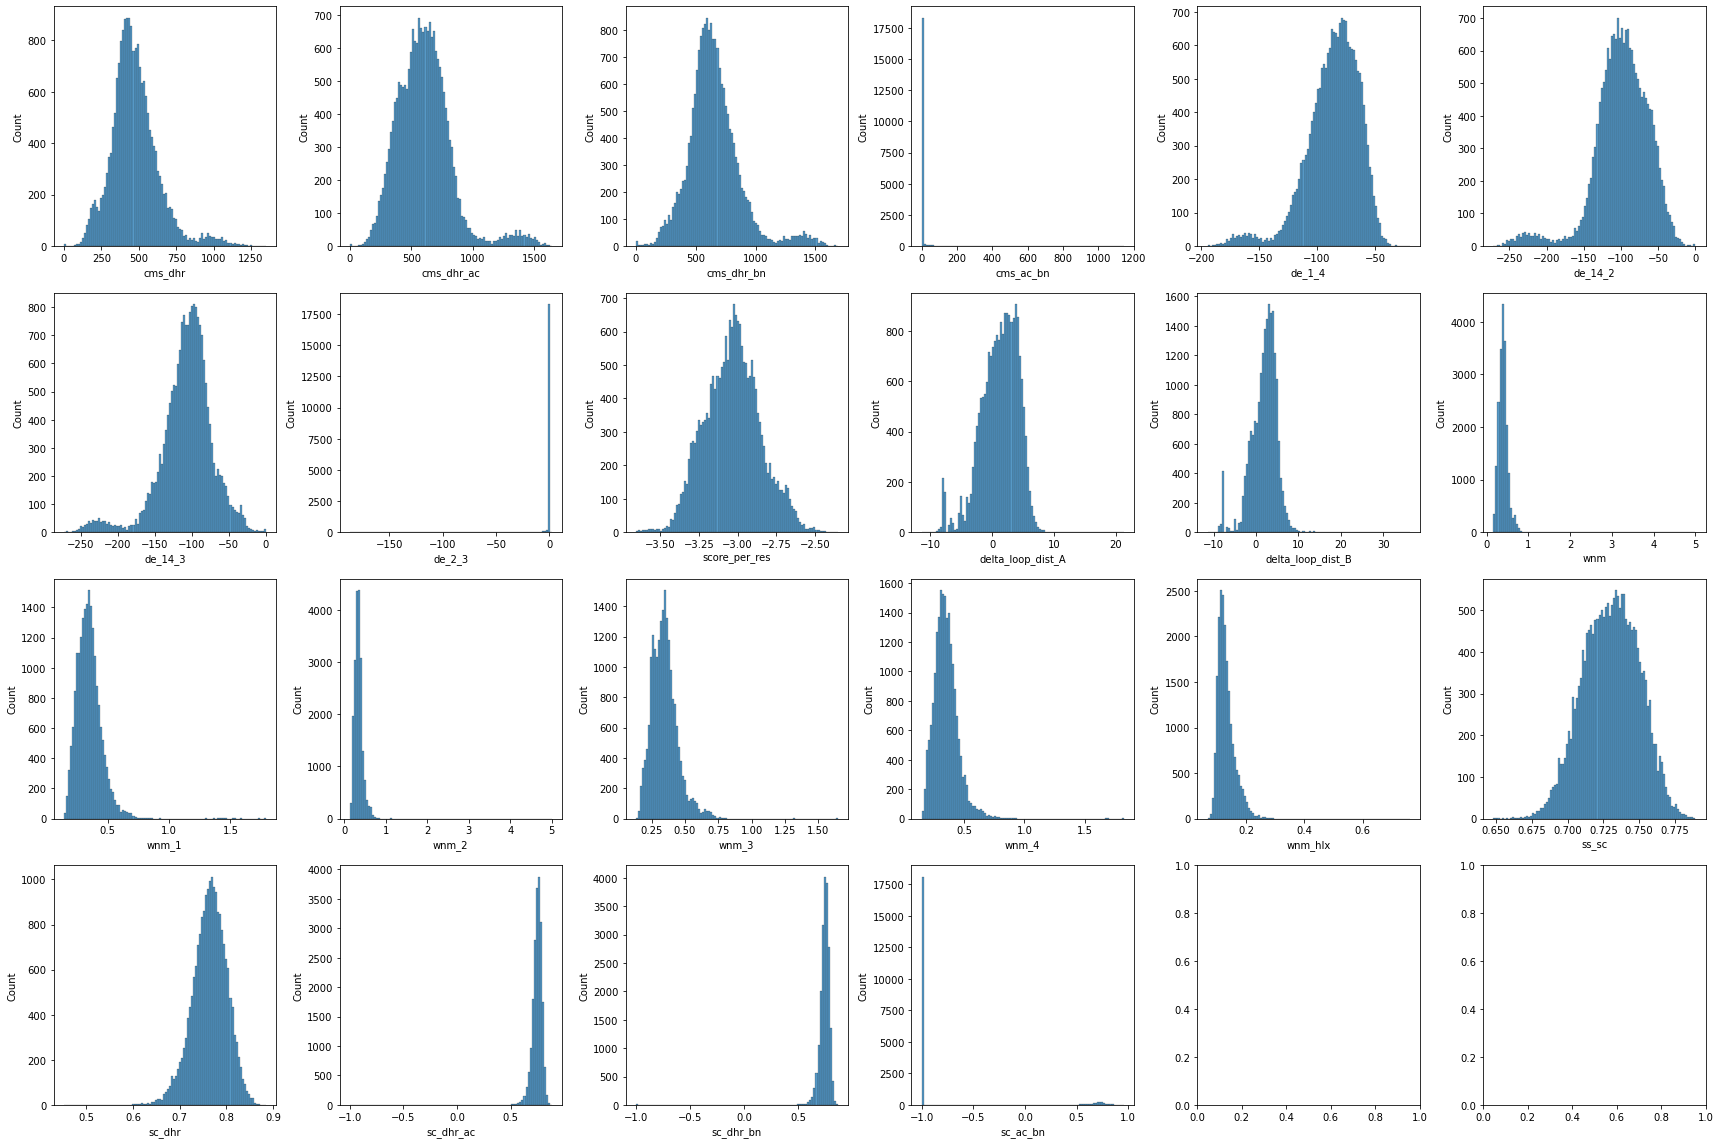

In [7]:
import sys
sys.path.insert(0, '/home/broerman/projects/crispy_shifty/')
from crispy_shifty.plotting.utils import histplot_df

cols = [
        "cms_dhr",
        "cms_dhr_ac",
        "cms_dhr_bn",
        "cms_ac_bn",
        "de_1_4",
        "de_14_2",
        "de_14_3",
        "de_2_3",
        "score_per_res",
        "delta_loop_dist_A",
        "delta_loop_dist_B",
        "wnm",
        "wnm_1",
        "wnm_2",
        "wnm_3",
        "wnm_4",
        "wnm_hlx",
        "ss_sc",
        "sc_dhr",
        "sc_dhr_ac",
        "sc_dhr_bn",
        "sc_ac_bn"
    #     "parent",
    ]

# make sure all the columns to plot are numeric
scores_df[cols] = scores_df[cols].astype(float)
histplot_df(scores_df, cols=cols, bins=100)

In [8]:
def filter_df(df, cutoffs):
    filtered_df = df

    for score_term, cutoff, greaterthan in cutoffs:
        if greaterthan:
            filtered_df = filtered_df[filtered_df[score_term] > cutoff]
        else:
            filtered_df = filtered_df[filtered_df[score_term] < cutoff]

    print(len(filtered_df))
    
    return filtered_df

def filter_df_delta(df, parent_df, delta_cutoffs):
    filtered_df = df

    for score_term, parent_term, cutoff, greaterthan in delta_cutoffs:
        filtered_series = filtered_df[score_term]
        parent_scores = parent_df.loc[filtered_df['parent'], parent_term]
        parent_scores.index = filtered_series.index
        # print(filtered_series)
        # print(parent_scores)
        # print(parent_scores - filtered_series < cutoff)
        if greaterthan:
            filtered_df = filtered_df[filtered_series - parent_scores > -cutoff]
        else:
            filtered_df = filtered_df[filtered_series - parent_scores < cutoff]
    
    print(len(filtered_df))
    
    return filtered_df

In [9]:
# Filter designs- remove worst by worst9mer and whether the designs are exploded

cutoffs = [('cms_dhr', 1, 1),
           ('cms_dhr_ac', 1, 1),
           ('cms_dhr_bn', 1, 1),
           ('wnm', 0.4, 0),
           ('wnm_hlx', 0.15, 0)
]

filtered_df = filter_df(scores_df, cutoffs)

9748


In [13]:
filtered_df['parent'].nunique()

176

22it [00:02,  9.14it/s]


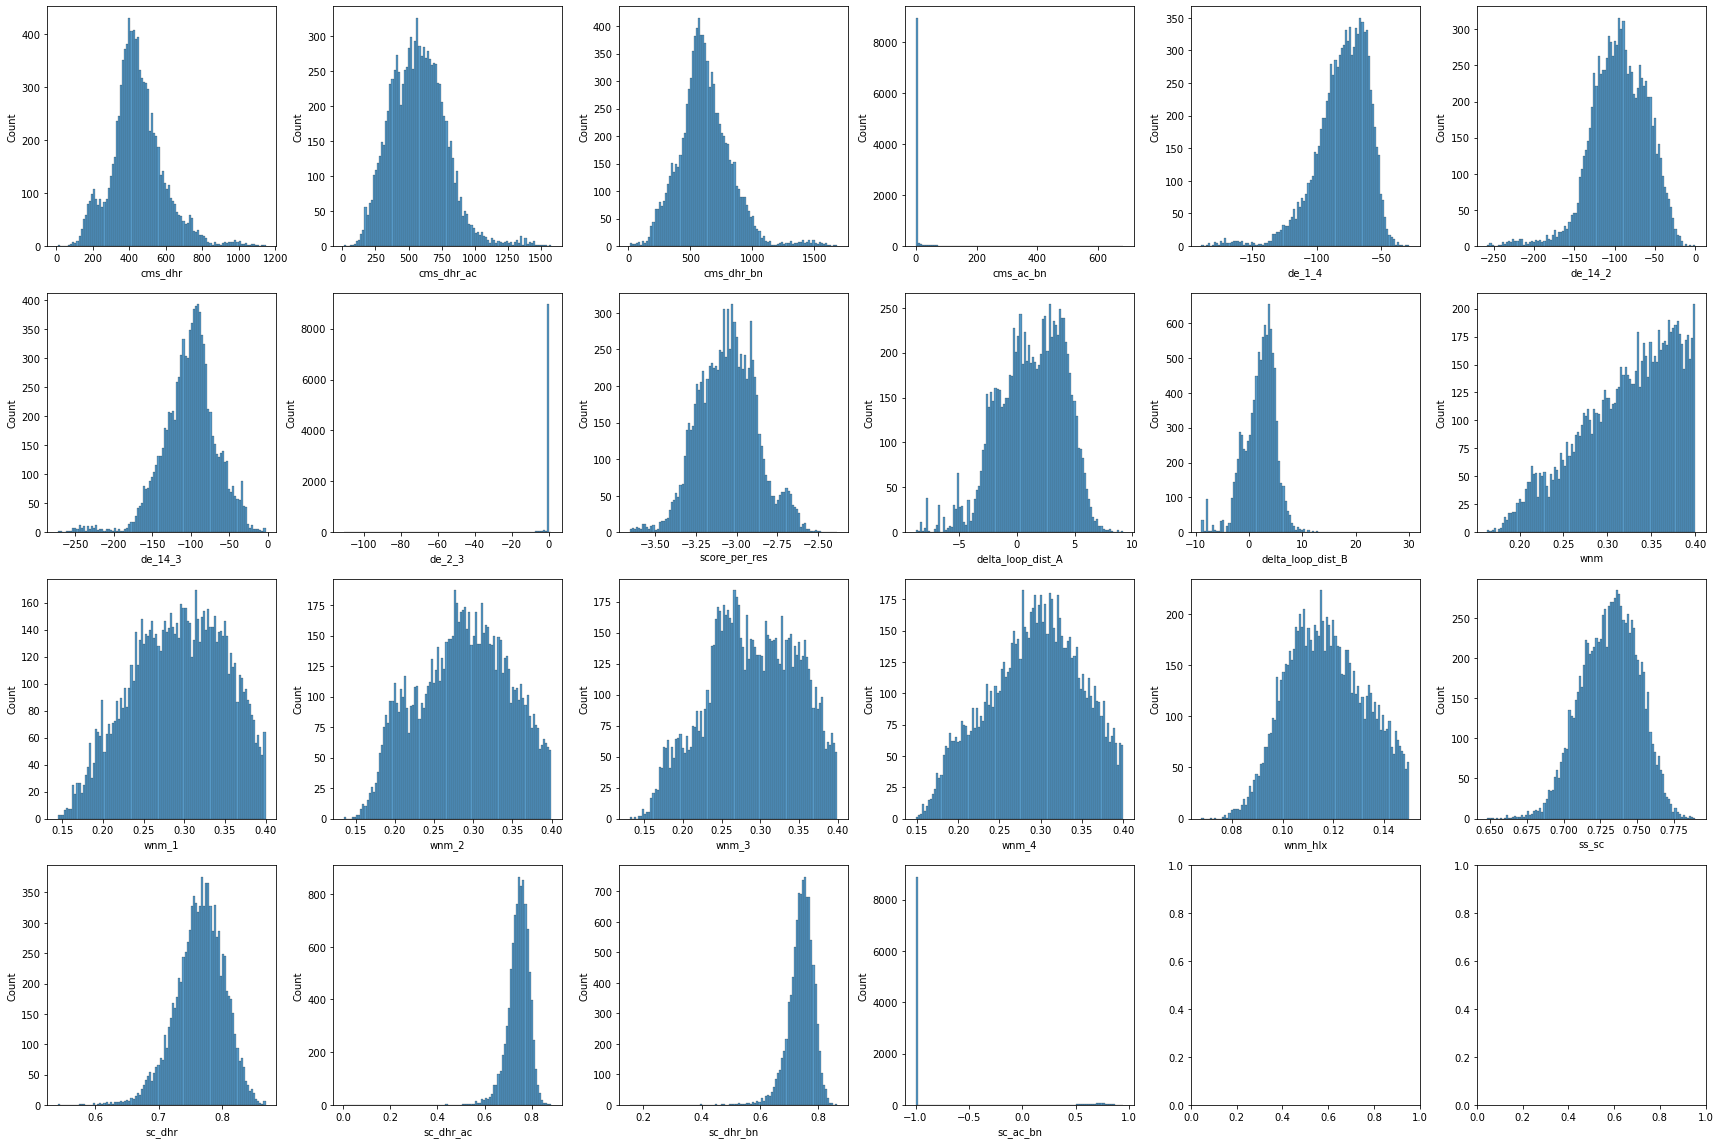

In [10]:
histplot_df(filtered_df, cols=cols, bins=100)

In [13]:
# Print some designs with a low cms_dhr to see what's going on
filtered_df[(filtered_df['cms_dhr'] < 250) & (filtered_df['cms_dhr'] > 100)].head()

,bb_clash,bb_clash_A,bb_clash_B,cms_ac_bn,cms_dhr,cms_dhr_ac,cms_dhr_bn,dhr_ac_int_count,dhr_bn_int_count,dhr_int_count,...,wnm_4,wnm_hlx,yhh_planarity,de_1_4,de_14_2,de_14_3,de_2_3,wnm,delta_loop_dist_A,delta_loop_dist_B
/mnt/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/02_design_filter_2/decoys/0000/02_design_filter_ace7a3318b364324979390173c9c9bab.pdb.bz2,3342.748291015625,3297.4052734375,45.342857360839844,0.483000,172.356171,172.356171,554.257812,11.0,19.0,13.0,...,0.284220,0.089483,0.0,-58.232925,-30.852478,-89.713928,0.112335,0.334952,-0.791585,4.074121
/mnt/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/02_design_filter_2/decoys/0000/02_design_filter_a2a24b37803940cfade4317bb3ccaf50.pdb.bz2,1768.426025390625,34.77348327636719,1672.2900390625,-1.000000,157.622955,499.079773,359.177399,18.0,26.0,21.0,...,0.288063,0.136389,0.0,-64.345970,-79.559921,-62.742615,0.000015,0.389461,2.725537,2.776847
/mnt/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/02_design_filter_2/decoys/0000/02_design_filter_1f921902b3884cb2ade6f3216439c856.pdb.bz2,101.75830841064453,40.49620056152344,40.557247161865234,-1.000000,136.587479,174.148849,604.038330,8.0,29.0,17.0,...,0.211732,0.109092,0.0,-56.955475,-31.532455,-95.561768,0.000015,0.221579,3.343186,2.620572
/mnt/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/02_design_filter_2/decoys/0000/02_design_filter_c8593bba06dd463f852ebb5cc36ca93e.pdb.bz2,117.68179321289062,45.54097366333008,72.13697814941406,10.553129,229.766373,422.049255,761.922424,15.0,38.0,18.0,...,0.283505,0.115204,7.841247984252675e-09,-70.646164,-60.071442,-122.189270,-0.738861,0.364781,-0.793242,4.757802
/mnt/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/02_design_filter_2/decoys/0000/02_design_filter_3519c55af97f471ea46c7f5347824492.pdb.bz2,284.741943359375,240.59005737304688,44.15187454223633,-1.000000,194.681885,230.821686,476.038879,11.0,7.0,10.0,...,0.278152,0.101630,0.011352269318261943,-66.088638,-32.908875,-74.176590,-0.000015,0.293735,5.555347,4.347504


In [11]:
parent_path = os.path.join(os.getcwd(), "00_inputs")
parent_scores = os.path.join(parent_path, "scaffold_scores.json")
parent_df = read_scorefile(parent_scores)
parent_df.set_index('name', inplace=True) # replaces the indexing by path to indexing by name
parent_df.head()

,cms_dhr,dslf_fa13,fa_atr,fa_dun_dev,fa_dun_rot,fa_dun_semi,fa_elec,fa_intra_atr_xover4,fa_intra_elec,fa_intra_rep_xover4,...,score,score_1,score_12,score_2,score_per_res,ss_sc,total_score,wnm_1,wnm_2,wnm_hlx
name,,,,,,,,,,,,,,,,,,,,,
DHR79,465.784760,0.0,-1400.636238,20.246144,145.179909,274.889648,-579.788253,-75.762132,-46.974228,73.894970,...,-561.677002,-245.034546,-561.677002,-251.905350,-2.553077,0.698439,-561.676986,0.322625,0.316925,0.094490
DHR39,321.138519,0.0,-1021.834993,17.066784,143.013018,193.845212,-399.394071,-59.330212,-31.171610,63.490618,...,-385.315033,-170.901306,-385.315033,-169.123169,-2.335243,0.731973,-385.315035,0.377876,0.327590,0.085988
DHR82,521.558899,0.0,-1498.559091,21.318266,188.024945,262.872950,-583.674273,-79.204600,-40.859747,99.079365,...,-621.641541,-269.689850,-621.641541,-283.966553,-2.726498,0.744233,-621.641546,0.226993,0.237057,0.110452
DHR53,357.954865,0.0,-1060.006597,10.302994,129.002023,184.958473,-407.824125,-53.968461,-22.101187,61.719093,...,-457.311920,-204.453018,-457.311920,-195.076950,-2.722095,0.788842,-457.311918,0.384927,0.392240,0.087457
DHR54,401.634857,0.0,-1047.650966,13.488556,126.581043,188.660628,-426.607112,-60.735843,-40.887647,66.710380,...,-449.422302,-189.710556,-449.422302,-196.766571,-2.643661,0.702949,-449.422302,0.279068,0.318838,0.076508


0it [00:00, ?it/s]

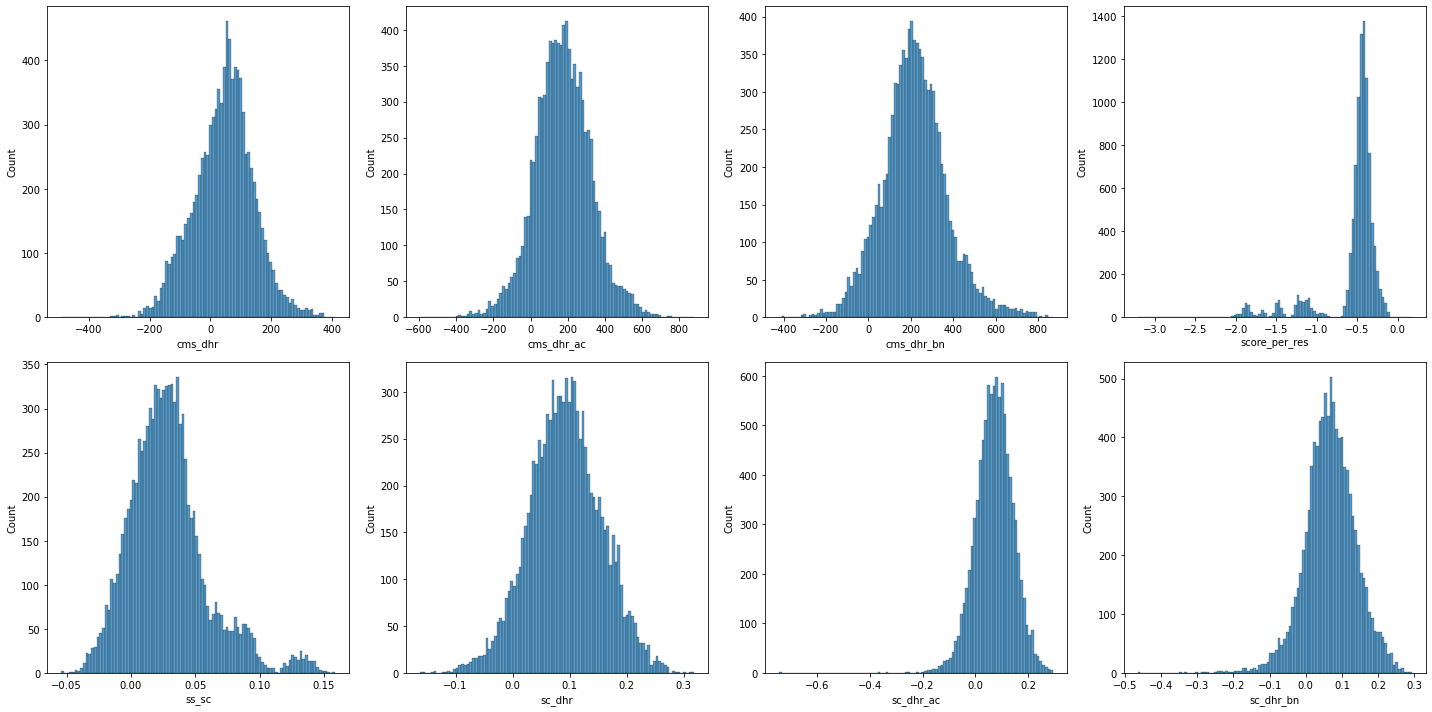

In [14]:
# Plots distributions of delta scores between the parent and the children.
# Delta scores are calculated by design_value - parent_value.
# For scores which I'm trying to maximize, higher delta values are better.
# Conclusion: all score_per_res are better than the parents, and sc and cms usually increase, even for the side domains!
# Only cms_dhr decreases significantly from the parent.
# So, let's just filter based on whether designs are as good as or better than the parent (cutoffs at 0).

delta_pairs = [('cms_dhr', 'cms_dhr'),
               ('cms_dhr_ac', 'cms_dhr'),
               ('cms_dhr_bn', 'cms_dhr'),
               ('score_per_res', 'score_per_res'),
               ('ss_sc', 'ss_sc'),
               ('sc_dhr', 'sc_dhr'),
               ('sc_dhr_ac', 'sc_dhr'),
               ('sc_dhr_bn', 'sc_dhr')]

score_terms, parent_terms = tuple(map(list, zip(*delta_pairs)))
# gets the columns to filter on from the parent df, then duplicate rows by parent such that rows correspond to the parents of the rows of filtered df
parent_aligned_df = parent_df[parent_terms].loc[filtered_df['parent'], :]
parent_aligned_df.index = filtered_df.index
parent_aligned_df.columns = score_terms # fixes an issue with duplicate column names, and makes sure the output columns are correctly named
delta_df = filtered_df[score_terms] - parent_aligned_df

fig, axs = plt.subplots(2, 4, figsize=(20,10))

for col, ax in tqdm(zip(score_terms, axs.flatten())):
    sns.histplot(
        data=delta_df,
        x=col,
        ax=ax,
#         kde=True
#         hue='parent'
        bins=100
    )

plt.tight_layout()

In [ ]:
# Print some designs with a lower cms_dhr than the parent to see what's going on
delta_df[(delta_df['cms_dhr'] < -100) & (delta_df['cms_dhr'] > -130)].head()

# Looks like the presence of the side domains causes the parent dhr interface to shrink, with fewer boundary contacts.
# Apolar only cms could be a better metric here, though it will also be skewed since with the side domains,
# apolar residues could be placed on the boundary of the parent dhr interface.
# I think the solution is to use a lenient delta cutoff for the cms parent dhr interface, say 100, to allow a little bit of interface shrinkage.

,cms_dhr,cms_dhr_ac,cms_dhr_bn,score_per_res,ss_sc,sc_dhr,sc_dhr_ac,sc_dhr_bn
/mnt/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/02_design_filter/decoys/0000/02_design_filter_fc65c483fba64651a33a7a4280802a90.pdb.bz2,-128.324829,-15.476837,-11.097046,-0.464113,0.029996,0.149985,0.049623,0.176675
/mnt/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/02_design_filter/decoys/0000/02_design_filter_ae90ece13b2e479f8610fe7a5f4cede9.pdb.bz2,-103.946136,-103.946136,277.955505,-0.399581,0.011160,0.049645,0.035773,0.069932
/mnt/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/02_design_filter/decoys/0000/02_design_filter_f947caa9d5a24efdb7e096252cda6ac5.pdb.bz2,-109.094025,18.668335,-62.761383,-0.511388,0.045362,0.109118,0.179763,0.006487
/mnt/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/02_design_filter/decoys/0000/02_design_filter_9f424837609845e2bc16d256aed1b41b.pdb.bz2,-100.655853,-75.516815,174.447723,-0.298625,-0.008390,0.005022,-0.020437,0.047412
/mnt/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/02_design_filter/decoys/0000/02_design_filter_5fde7a1ebffb41648bcdf8ae8587e5c9.pdb.bz2,-110.717682,166.518494,166.639526,-0.368412,0.038626,0.064437,0.031934,0.063684


In [ ]:
# And some designs with a higher cms_dhr than the parent
delta_df[(delta_df['cms_dhr'] > 100) & (delta_df['cms_dhr'] < 200)].head()

,cms_dhr,cms_dhr_ac,cms_dhr_bn,score_per_res,ss_sc,sc_dhr,sc_dhr_ac,sc_dhr_bn
/mnt/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/02_design_filter/decoys/0000/02_design_filter_24a47b3ebec14870976d8fb3704d2114.pdb.bz2,117.482407,126.579025,361.987137,-0.617763,0.086550,0.229636,0.196603,0.216418
/mnt/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/02_design_filter/decoys/0000/02_design_filter_53ea34509c2a438a95746302758bf218.pdb.bz2,124.810333,161.839264,21.770935,-0.266335,0.001674,0.067127,-0.010735,-0.060917
/mnt/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/02_design_filter/decoys/0000/02_design_filter_c3d98ecea90941858ec4cb366f50cb1b.pdb.bz2,149.607880,201.059631,37.525909,-0.484502,0.042451,0.178258,0.110098,0.126626
/mnt/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/02_design_filter/decoys/0000/02_design_filter_324408d0458442279aa33fea01874f5f.pdb.bz2,192.689819,255.290955,-90.790558,-0.438677,0.032071,0.179362,0.103441,-0.052351
/mnt/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/02_design_filter/decoys/0000/02_design_filter_ccf71c810cda479e983e21d5c33554d6.pdb.bz2,139.716431,291.310547,159.460968,-1.081181,0.089481,0.202259,0.111226,0.146697


In [15]:
# how do I determine these cutoffs? Look at distributions of delta cutoffs between the parent and the children

# here, "cutoff" means "if the design scores worse than the parent by x"
delta_cutoffs = [('cms_dhr', 'cms_dhr', 100, 1),
                 ('cms_dhr_ac', 'cms_dhr', 0, 1),
                 ('cms_dhr_bn', 'cms_dhr', 0, 1),
                 ('score_per_res', 'score_per_res', 0.2, 0),
                 ('ss_sc', 'ss_sc', 0, 1),
                 ('sc_dhr', 'sc_dhr', 0, 1),
                 ('sc_dhr_ac', 'sc_dhr', 0, 1),
                 ('sc_dhr_bn', 'sc_dhr', 0, 1)]

delta_filtered_df = filter_df_delta(filtered_df, parent_df, delta_cutoffs)

5980


In [16]:
delta_filtered_df['parent'].nunique()

144

In [17]:
delta_filtered_df.head()

,bb_clash,bb_clash_A,bb_clash_B,cms_ac_bn,cms_dhr,cms_dhr_ac,cms_dhr_bn,dhr_ac_int_count,dhr_bn_int_count,dhr_int_count,...,wnm_4,wnm_hlx,yhh_planarity,de_1_4,de_14_2,de_14_3,de_2_3,wnm,delta_loop_dist_A,delta_loop_dist_B
/mnt/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/02_design_filter_2/decoys/0000/02_design_filter_3f8b825fb7da4afea12f6088a0522e3e.pdb.bz2,100.22811889648438,50.11375427246094,50.11375427246094,-1.0,417.987396,518.198914,585.848511,23.0,22.0,20.0,...,0.310289,0.128212,0.0,-84.854980,-85.005432,-114.374527,0.000015,0.310289,-5.059126,4.324197
/mnt/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/02_design_filter_2/decoys/0000/02_design_filter_47f0102fdf9a49f98f1bb55e19de65d0.pdb.bz2,261.9366149902344,37.129581451416016,37.129581451416016,-1.0,316.494171,573.662842,421.352203,28.0,20.0,19.0,...,0.391887,0.117004,0.0,-49.306679,-97.840134,-69.341370,-0.000015,0.391887,-0.586154,2.463285
/mnt/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/02_design_filter_2/decoys/0000/02_design_filter_38705f44e5194ae79dd53c8be588b4d9.pdb.bz2,1356.5601806640625,1312.4459228515625,44.11418533325195,-1.0,552.996399,574.881348,474.947296,39.0,24.0,18.0,...,0.244698,0.101567,0.0,-67.792114,-88.441864,-74.894226,0.000000,0.298287,1.825097,5.000660
/mnt/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/02_design_filter_2/decoys/0000/02_design_filter_f59c8c4ac4884991adf53a11b41096a6.pdb.bz2,2617.639892578125,945.3499145507812,1672.2900390625,-1.0,254.665039,327.875763,381.594666,13.0,26.0,21.0,...,0.233850,0.131140,0.0,-63.413788,-43.370636,-67.999695,0.000000,0.265801,2.100627,2.266287
/mnt/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/02_design_filter_2/decoys/0000/02_design_filter_f0c11f5f2ed647dc90e8c31a100e14ed.pdb.bz2,559.2636108398438,49.52986526489258,269.9587707519531,-1.0,621.645264,663.730713,661.339478,30.0,55.0,16.0,...,0.203909,0.112960,0.0,-88.466980,-106.258636,-108.620361,0.000000,0.251911,-1.501627,5.080668


22it [00:01, 13.14it/s]


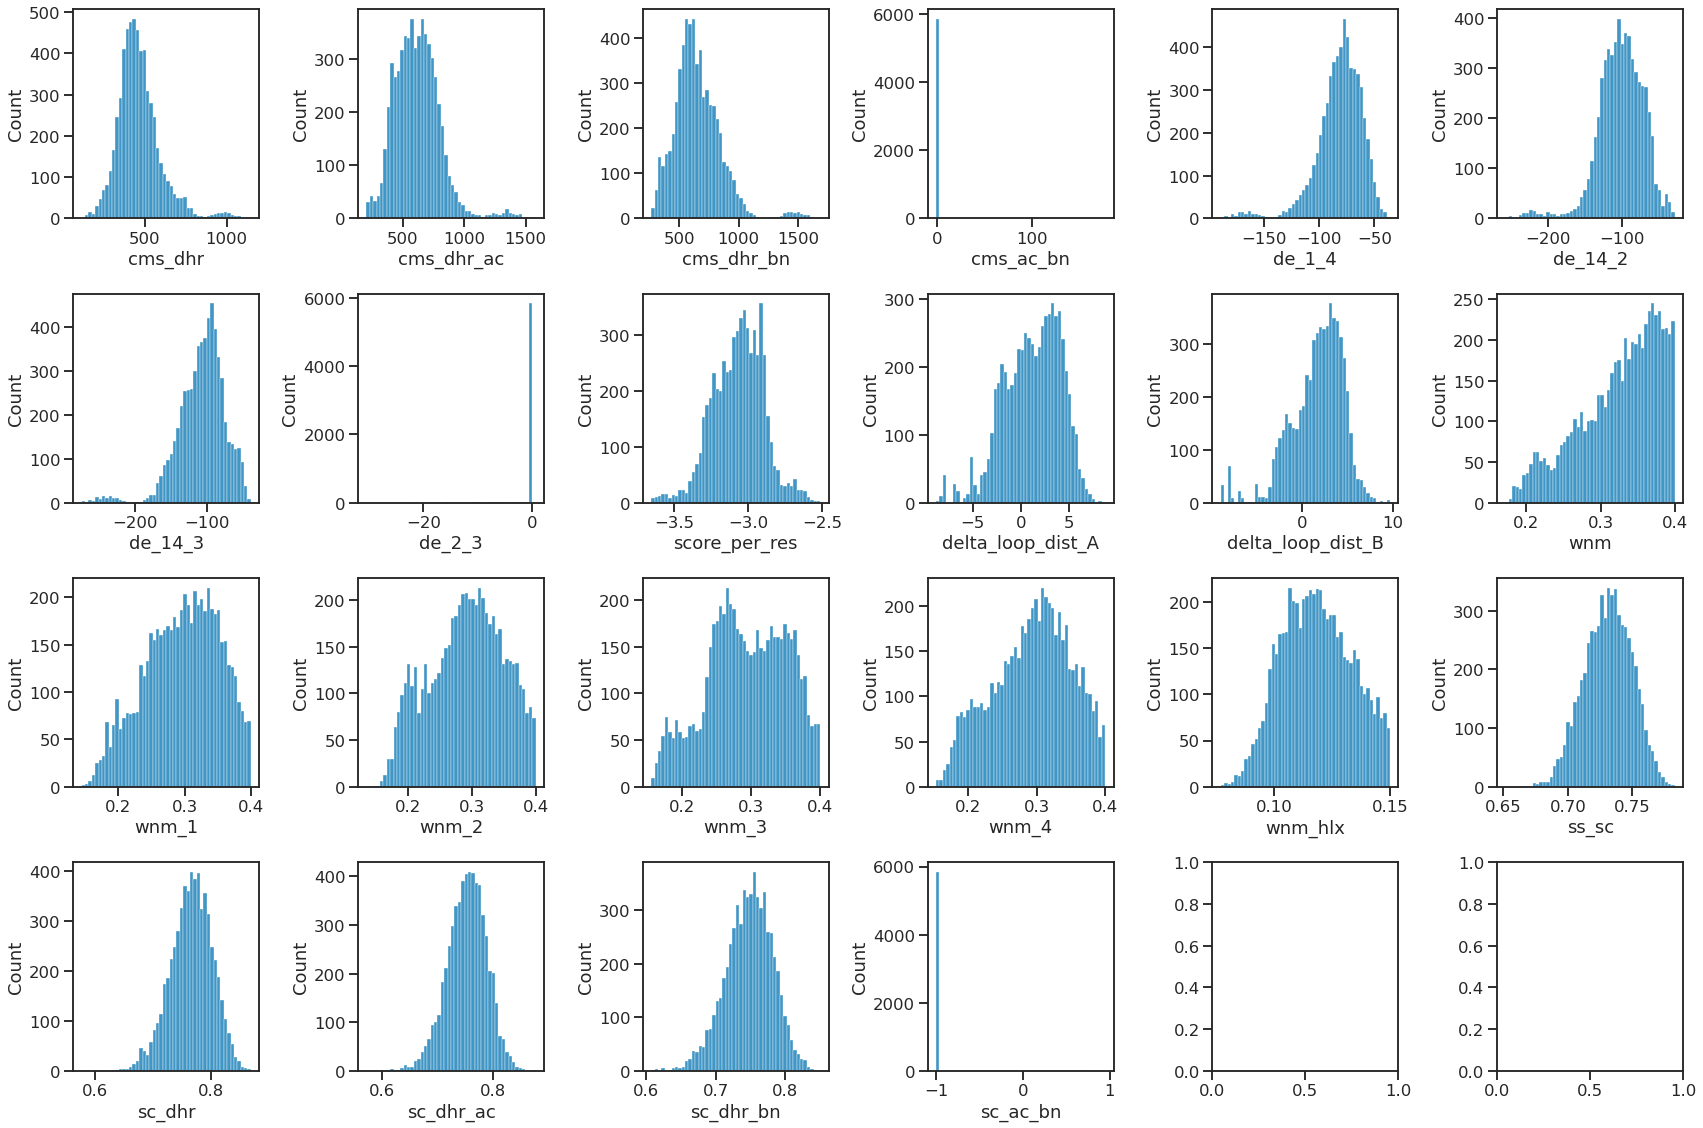

In [18]:
histplot_df(delta_filtered_df, cols=cols, bins=50)

In [ ]:
# Print some of the second cms peak to see if they are THRs.
filtered_df[(filtered_df['cms_dhr'] > 900)].head()

,bb_clash,bb_clash_A,bb_clash_B,cms_ac_bn,cms_dhr,cms_dhr_ac,cms_dhr_bn,dhr_ac_int_count,dhr_bn_int_count,dhr_int_count,...,wnm_4,wnm_hlx,yhh_planarity,de_1_4,de_14_2,de_14_3,de_2_3,wnm,delta_loop_dist_A,delta_loop_dist_B
/mnt/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/02_design_filter/decoys/0000/02_design_filter_5611321baf9e45dd818718e3499dec18.pdb.bz2,1858.6153564453125,136.7066192626953,136.7066192626953,-1.0,931.114014,1324.395630,1379.208618,73.0,67.0,35.0,...,0.386356,0.118572,0.0,-170.655701,-220.189880,-222.227295,-0.000061,0.386356,1.836477,1.814585
/mnt/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/02_design_filter/decoys/0001/02_design_filter_6982c26d040f44a7b085d1d7b05a5875.pdb.bz2,710.5448608398438,93.95706939697266,93.95706939697266,-1.0,919.657104,1308.585327,1495.255249,56.0,75.0,31.0,...,0.304422,0.119503,0.0,-178.142487,-211.855896,-242.634674,0.000031,0.355099,2.524035,1.423097
/mnt/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/02_design_filter/decoys/0003/02_design_filter_05b8f80990ed401489a015828e1782ff.pdb.bz2,1161.6591796875,93.95706939697266,1067.7021484375,-1.0,957.721863,1382.148315,1471.747925,56.0,84.0,31.0,...,0.318141,0.114490,0.0,-173.107483,-219.464722,-238.964111,0.000000,0.334877,2.538482,0.990540
/mnt/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/02_design_filter/decoys/0006/02_design_filter_b2c2025d3fe3471fba544b97e0845b61.pdb.bz2,4684.25537109375,415.87322998046875,4268.38232421875,-1.0,1039.502075,1210.291504,1311.909180,59.0,79.0,32.0,...,0.388562,0.122882,0.0,-169.250641,-201.625244,-199.020660,0.000031,0.388562,0.671074,1.295882
/mnt/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/02_design_filter/decoys/0006/02_design_filter_33a3a3dbe07c40a3923ef91024fdd64d.pdb.bz2,4361.7734375,93.39134216308594,4268.38232421875,-1.0,1017.487244,1382.243408,1308.317993,61.0,79.0,32.0,...,0.364463,0.124909,0.0,-158.107056,-230.215424,-205.285248,0.000000,0.394730,-0.491061,1.295882


In [ ]:
# Nope, they're actually super long TH_DHRs.
# Did any THRs make it? Yes!
filtered_df[(filtered_df['pre_break_helix'] == '6.0')].head()

,bb_clash,bb_clash_A,bb_clash_B,cms_ac_bn,cms_dhr,cms_dhr_ac,cms_dhr_bn,dhr_ac_int_count,dhr_bn_int_count,dhr_int_count,...,wnm_4,wnm_hlx,yhh_planarity,de_1_4,de_14_2,de_14_3,de_2_3,wnm,delta_loop_dist_A,delta_loop_dist_B
/mnt/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/02_design_filter/decoys/0000/02_design_filter_cc0804dd5dab4653a606f6cef0fa8a8f.pdb.bz2,668.2564086914062,79.41667938232422,76.21759033203125,517.715881,307.120026,307.120026,536.304993,19.0,35.0,11.0,...,0.365453,0.116165,5.1897351971419425e-09,-88.877502,-50.799286,-86.879150,-88.783539,0.369996,-2.610209,3.678906
/mnt/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/02_design_filter/decoys/0000/02_design_filter_8d037d54967543d9b749056cdbc3ad5c.pdb.bz2,152.4293670654297,76.1240463256836,76.3053207397461,312.245422,357.603577,357.603577,811.348511,19.0,33.0,15.0,...,0.355521,0.143304,0.0,-125.721466,-56.937469,-138.479797,-43.052338,0.380786,1.667954,2.055666
/mnt/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/02_design_filter/decoys/0000/02_design_filter_5611321baf9e45dd818718e3499dec18.pdb.bz2,1858.6153564453125,136.7066192626953,136.7066192626953,-1.000000,931.114014,1324.395630,1379.208618,73.0,67.0,35.0,...,0.386356,0.118572,0.0,-170.655701,-220.189880,-222.227295,-0.000061,0.386356,1.836477,1.814585
/mnt/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/02_design_filter/decoys/0003/02_design_filter_ae123d6a369142ebb7f337cce05976bb.pdb.bz2,292.32464599609375,142.95269775390625,149.3719482421875,248.159149,421.329895,421.329895,790.366211,29.0,43.0,23.0,...,0.383369,0.121529,0.0,-123.729431,-66.783966,-130.769470,-34.588898,0.391315,2.311994,-0.613650
/mnt/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/02_design_filter/decoys/0004/02_design_filter_6f45dca628604f61a89ef820da9a4829.pdb.bz2,343.88153076171875,194.50958251953125,149.3719482421875,305.212189,459.352905,459.352905,733.136169,28.0,43.0,23.0,...,0.354774,0.142260,0.0,-118.002136,-69.143097,-117.863068,-48.407532,0.395654,1.647608,-0.613650


In [19]:
filtered_json_path = os.path.join(output_path_2, "filtered_designs.json")
delta_filtered_df.to_json(filtered_json_path)
filtered_list_path = os.path.join(output_path_2, "filtered_designs.list")
with open(filtered_list_path, 'w') as f:
    f.write('\n'.join(delta_filtered_df.index))

In [22]:
# print 50 random designs to load into pymol, just to check that everything looks good.
print(';'.join('load ' + path for path in delta_filtered_df.sample(50).index))

# Overall, these all look great!
# I could try filtering more on delta_loop_dist (this gets high particularly for B), but since looping is so fast, I think I'll just loop
# everything and see how delta_loop_dist is correlated with loop success later.

load /home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/02_design_filter_3/decoys/0004/_d721c6a1eced45caab60d0c7e112bbc1.pdb.bz2;load /home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/02_design_filter_3/decoys/0006/_2094821188164cd98f573aaa97aab4ea.pdb.bz2;load /home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/02_design_filter_3/decoys/0000/_83f3ea3887c143b7bbe4bbeeb1273634.pdb.bz2;load /home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/02_design_filter_3/decoys/0003/_c880ca1648964de7aa113b4827a1fb67.pdb.bz2;load /mnt/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/02_design_filter_2/decoys/0011/02_design_filter_f4fe4ae2892b4e6daefe257e16037303.pdb.bz2;load /mnt/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/02_design_filter_2/decoys/0000/02_design_filter_41933ebfe5ac4a41bd27eba4e002b4a1.pdb.bz2;load /mnt/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/02_desi

## Everything after this is for testing ##

In [20]:
from copy import deepcopy
test_df = deepcopy(filtered_df)

In [ ]:
# testing

sys.path.insert(0, "/home/broerman/projects/crispy_shifty")
from crispy_shifty.protocols.design import one_state_design_unlooped_dimer

pyrosetta.distributed.maybe_init(**{
    "options": "-corrections::beta_nov16 true",
    "extra_options":{
        "-out:level": "100",
        "-holes:dalphaball": "/home/bcov/ppi/tutorial_build/main/source/external/DAlpahBall/DAlphaBall.gcc",
        "-indexed_structure_store:fragment_store": "/home/bcov/sc/scaffold_comparison/data/ss_grouped_vall_all.h5",
        "-precompute_ig": "true"
}})

import pyrosetta.distributed.io as io
file = '/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/01_make_states/decoys/0000/CSD_01_make_states_4c315eabb34a449a886b9e9bd9b8227a.pdb.bz2'

for i in tqdm(range(1)):
    pposes = one_state_design_unlooped_dimer(None, **{'pdb_path': file})
    for ppose in pposes:
        designed_pose = io.to_pose(ppose)
        # designed_pose.dump_pdb(f"/home/broerman/projects/dimeric_hinges/dimeric_hinges_2/testing/02_design_filter/X23_3_20_3_ct7_fc.pdb")
        designed_pose.dump_pdb(f"/home/broerman/projects/dimeric_hinges/dimeric_hinges_2/testing/02_design_filter/X23_3_20_3_ct7_fc_fixbb2_{i:02d}.pdb")

  0%|          | 0/1 [00:00<?, ?it/s]

0.00 min: Generated interface selector
0.00 min: Generated interface design task factory
0.06 min: Generated score functions
0.06 min: Generated movemaps


/projects/crispy_shifty/envs/crispy/lib/python3.8/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


select design_sel, (chain A and resid 2,6,28,31,32,35,38,39,42,46,49,50,51,52,54,55,56,58,59,61,62,65,66,69,73,75,77,78,80,81,82,84,85,87,88,89,90,91,92,93,94,95) or (chain B and resid 103,106,107,109,110,113,114,117,122,123,125,126,127,129,130,132,133,134,136,137,140,182) or (chain C and resid 245,247,248,251,252,254,255,256,258,259,262,263,265,266,268,270,271,274,275,277,278,279,281,282,284,285) or (chain D and resid 289,290,291,292,293,294,295,296,297,299,300,301,303,304,306,307,308,310,315,318,319,322,323,325,326,327,329,330,332,333,334,342,346,349,350,353,356,360)
0.21 min: Generating structure profile...complete.
0.21 min: Starting 1 round of fixed backbone design...complete.
36.09 min: Starting 2 rounds of flexible backbone design...complete.
36.09 min: Clearing constraints...complete.
36.09 min: Scoring contact molecular surface and shape complementarity...core.scoring.sc.ShapeComplementarityCalculator: {0} [ ERROR ] Failed: No molecular dots generated!
protocols.simple_filters

In [ ]:
# testing

sys.path.insert(0, "/home/broerman/projects/crispy_shifty")
from crispy_shifty.protocols.design import one_state_design_unlooped_dimer

pyrosetta.distributed.maybe_init(**{
    "options": "-corrections::beta_nov16 true",
    "extra_options":{
        "-out:level": "100",
        "-holes:dalphaball": "/home/bcov/ppi/tutorial_build/main/source/external/DAlpahBall/DAlphaBall.gcc",
        "-indexed_structure_store:fragment_store": "/home/bcov/sc/scaffold_comparison/data/ss_grouped_vall_all.h5",
        "-precompute_ig": "true"
}})

import pyrosetta.distributed.io as io
file = '/home/broerman/projects/dimeric_hinges/dimeric_hinges_2/testing/01_make_states/DHR21/DHR21_A_-1_0_DHR21_B_1_1.pdb'

for i in tqdm(range(1)):
    pposes = one_state_design_unlooped_dimer(None, **{'pdb_path': file})
    for ppose in pposes:
        designed_pose = io.to_pose(ppose)
        # designed_pose.dump_pdb(f"/home/broerman/projects/dimeric_hinges/dimeric_hinges_2/testing/02_design_filter/X23_3_20_3_ct7_fc.pdb")
        designed_pose.dump_pdb(f"/home/broerman/projects/dimeric_hinges/dimeric_hinges_2/testing/02_design_filter/DHR21_{i:02d}.pdb")

  0%|          | 0/1 [00:00<?, ?it/s]

0.00 min: Generated interface selector
0.00 min: Generated interface design task factory
0.06 min: Generated score functions
0.06 min: Generated movemaps


/projects/crispy_shifty/envs/crispy/lib/python3.8/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


select design_sel, (chain A and resid 2,5,9,25,28,38,39,40,42,43,44,46,47,50,51,54,55,59,60,62,63,64,66,67,69,70,71,73) or (chain B and resid 74,76,77,78,80,81,82,84,85,87,88,96,100,103,104,107,108) or (chain C and resid 151,187,188,189,190,192,193,195,196,197,199,200,203,204,208,209,211,212,213,215,216,217,218,219,220,221,222) or (chain D and resid 224,226,227,229,230,231,233,234,235,236,237,238,240,245,246,247,249,250,252,253,254,256,257,259,268,269,272,275,276)
0.22 min: Generating structure profile...complete.
5.91 min: Starting 1 round of fixed backbone design...complete.
32.86 min: Starting 2 rounds of flexible backbone design...complete.
88.69 min: Clearing constraints...complete.
88.69 min: Scoring contact molecular surface and shape complementarity...core.scoring.sc.ShapeComplementarityCalculator: {0} [ ERROR ] Failed: No molecular dots generated!
protocols.simple_filters.ShapeComplementarityFilter: {0} [ ERROR ] Issue running shape complementarity calculator - returning -1 in